# Dask Client for Larger Datasets

In this section, we will analyse a larger dataset over multiple time-steps. We will use the Dask Client Dashboard to view the status of our computations.  

This section draws upon skills from the previous two sections including lazy-loading data, adding multiple tasks using `.compute()`, and visualise the task graph using `.visualise()`. 

## Load Packages

In [3]:
import datacube 
import matplotlib.pyplot as plt
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map

## Connecting to the datacube 

In [4]:
dc = datacube.Datacube(app='Step3')

## Create a Dask Cluster

In [5]:
create_local_dask_cluster()

/usr/local/lib/python3.8/dist-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42079 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:46737 Dashboard: /user/mseehaber@frontiersi.com.au/proxy/42079/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


Returning this will show information about the Client and Cluster. For this exercise we will use the hyperlink to the Dashboard. This link will allow you to view the progress of your computations as they are running.

To view the Dask dashboard and your active notebook at the same time, follow the hyperlink and open in a new window. 

## Lazy-loading data

In [6]:
lazy_data = dc.load(product='gm_s2_semiannual',
                   measurements=['blue','green','red','nir'],
                   x=(30.1505, 30.4504),
                   y=(30.0899, 30.3898),
                   time=('2020-01-01', '2021-12-31'),
                   dask_chunks={'time':1,'x':1500, 'y':1700})

lazy_data

<xarray.Dataset>
Dimensions:      (time: 4, y: 3317, x: 2895)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-31T23:59:59.999999 ... 2021-09...
  * y            (y) float64 3.702e+06 3.702e+06 ... 3.669e+06 3.669e+06
  * x            (x) float64 2.909e+06 2.909e+06 ... 2.938e+06 2.938e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Multiple tasks using .compute() 
In this section, you will chain multiple steps together to calculate a new band for the data array. Using the red and nir bands, we will calculate the Normalised Difference Vegetation Index (NDVI).

In [11]:
# calcualte NDVI using red and nir bands from array
band_diff = lazy_data.nir - lazy_data.red
band_sum = lazy_data.nir + lazy_data.red

# added ndvi dask array to the lazy_data dataset
lazy_data['ndvi'] = band_diff/ band_sum

# return the dataset 
lazy_data

<xarray.Dataset>
Dimensions:      (time: 4, y: 3317, x: 2895)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-31T23:59:59.999999 ... 2021-09...
  * y            (y) float64 3.702e+06 3.702e+06 ... 3.669e+06 3.669e+06
  * x            (x) float64 2.909e+06 2.909e+06 ... 2.938e+06 2.938e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 1700, 1500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

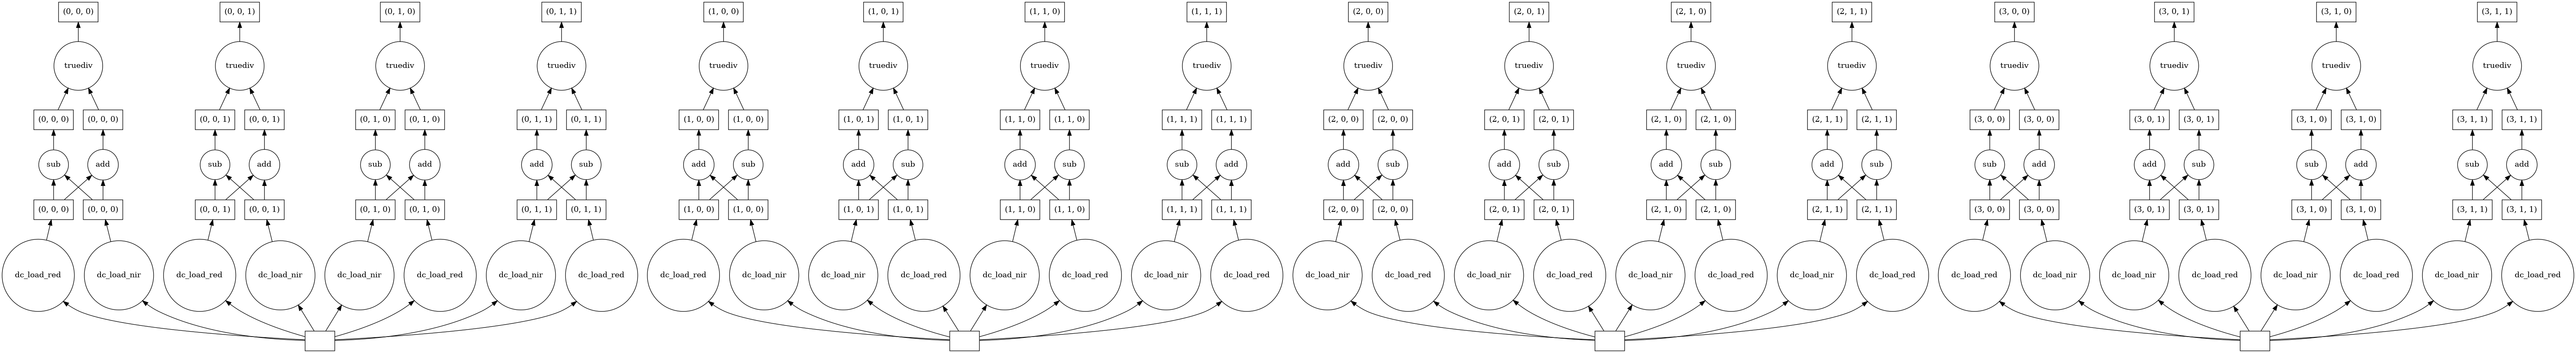

In [12]:
lazy_data.ndvi.data.visualize()

From viewing the task graph, we can now see the NDVI equation taking place across all four time-steps within our two-year time range. Each time-step is signified by a separate database entry at the bottom of the task graph (see single highlighted time-step below).  

## Viewing the Dashboard while computing 
Ensure your new window with the Dask Dashboard is visible and run the following cell:

In [13]:
lazy_data_ndvi_compute = lazy_data.ndvi.compute()
lazy_data_ndvi_compute

<xarray.DataArray 'ndvi' (time: 4, y: 3317, x: 2895)>
array([[[0.06942078, 0.07080692, 0.0696223 , ..., 0.08328466,
         0.08114312, 0.08132118],
        [0.06951645, 0.0696682 , 0.06692324, ..., 0.08635357,
         0.0831899 , 0.07955576],
        [0.06737811, 0.06848731, 0.06940029, ..., 0.08616674,
         0.08235834, 0.07685342],
        ...,
        [0.38583474, 0.43568613, 0.4921664 , ..., 0.1825495 ,
         0.18272629, 0.18238801],
        [0.30237789, 0.37975794, 0.45614666, ..., 0.18378126,
         0.18577805, 0.18638376],
        [0.20758178, 0.28623428, 0.39149965, ..., 0.17947142,
         0.18378543, 0.18722567]],

       [[0.06175587, 0.06195676, 0.0608138 , ..., 0.07257672,
         0.07069745, 0.07147104],
        [0.06372657, 0.06219042, 0.05804492, ..., 0.07568556,
         0.07152239, 0.06959707],
        [0.06023316, 0.05772772, 0.05621204, ..., 0.07639401,
         0.07051051, 0.06657224],
...
        [0.50187138, 0.51266042, 0.54626763, ..., 0.09506223,
         0.09237813, 0.09149278],
        [0.3803492 , 0.46448664, 0.5345694 , ..., 0.09328612,
         0.09230149, 0.09234264],
        [0.2332595 , 0.35116818, 0.48972061, ..., 0.09416427,
         0.09450847, 0.0938633 ]],

       [[0.06011664, 0.06107649, 0.05899572, ..., 0.06922051,
         0.06808663, 0.06809524],
        [0.06101091, 0.06024636, 0.05826772, ..., 0.07232165,
         0.0690321 , 0.06698507],
        [0.05838208, 0.05756208, 0.06089405, ..., 0.07196642,
         0.06814041, 0.06525912],
        ...,
        [0.07636253, 0.07974138, 0.08053382, ..., 0.08965897,
         0.0869683 , 0.0873734 ],
        [0.07742436, 0.07760673, 0.07651878, ..., 0.08991228,
         0.08896701, 0.08775236],
        [0.07300672, 0.07317073, 0.07252679, ..., 0.09073517,
         0.09058855, 0.08816799]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-03-31T23:59:59.999999 ... 2021-09...
  * y            (y) float64 3.702e+06 3.702e+06 ... 3.669e+06 3.669e+06
  * x            (x) float64 2.909e+06 2.909e+06 ... 2.938e+06 2.938e+06
    spatial_ref  int32 6933

## Plotting the NDVI timeseries

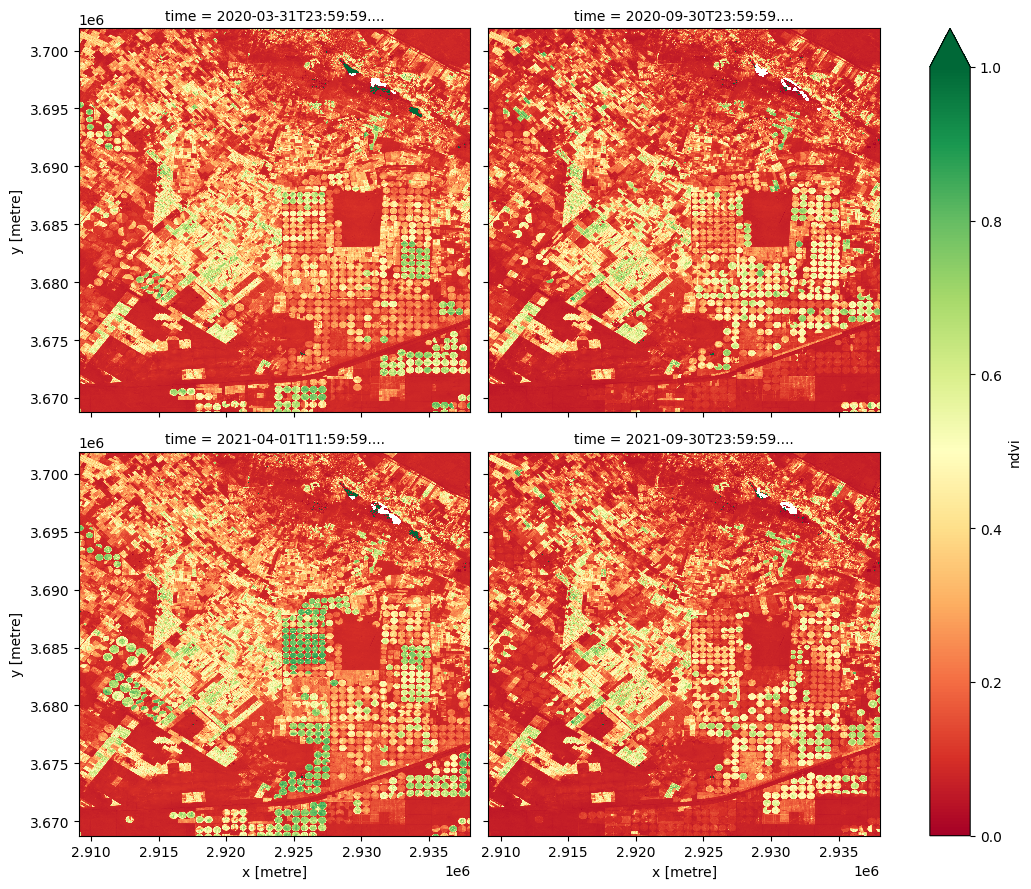

In [14]:
lazy_data_ndvi_compute.plot(col='time', col_wrap= 2, cmap='RdYlGn',figsize=(11, 9),vmin=0, vmax=1)

### Key Concepts
* The `create_local_dask_cluster()` function takes advantage of multiple CPU cores to speed up computations, known as distributed computing
* Dask dashboard allows us to view the progress of computations as they run in real-time

#### Further information 

##### Dask Client
Dask can use multiple computing cores (CPUs) in parallel to speed up computations, known as distributed computing. 

The deafrica_tools package provides us with access to support functions within the Dask module, including the `create_local_dask_cluster()` function, which allows us to take advantage of the multiple CPUs available in the Sandbox. 

##### Dask Dashboard
The status tab in the scheduler provides information on the following: 
* Bytes Stored: cluster memory and memory per worker 
* Task Processing: tasks being processed by each worker 
* Task Stream: shows the progress of each individual task across every thread, with each line corresponding to a thread. Each colour corresponds to a type of operation. 
* Progress: progress of individual computations 

The image below shows the task stream and progress bar progressing as the computations run. 

<img align="middle" src="../../_static/sandbox/dask-howto/dask-dashboard.png" alt="Dask dashboard progress comparison." width="1000">